In [1]:

"""

How to read a COCO JSON file to understand the structure of the data?

"""

import json

# Load the JSON file
with open(r"E:\Random Python Scripts\Tata HaxS\SAM\sam.v2i.coco-segmentation\test\_annotations.coco.json") as file:
    data = json.load(file)

# Print out the first few image filenames/paths
for img in data['images'][:10]:  # Adjust the number to print more or fewer paths
    print(img['file_name'])

385_jpg.rf.2b005aff758d12fc53bb47d288e0648e.jpg
403_jpg.rf.286275fef80620a43d38124fdfa11e91.jpg
391_jpg.rf.6a088df325f38521b78fee96f8aa065d.jpg
307_jpg.rf.57e393927e6134e7844db6eb618a69fa.jpg
530_jpg.rf.2da062217d4b1b495d9be9d0531a0dcf.jpg
139_jpg.rf.572d4242910bca5e7726f9517662043b.jpg
048_jpg.rf.69be897c06e44399625c96d0691abbd6.jpg
370_jpg.rf.1a6138642051dd9e01ba6de31868ee2d.jpg
395_jpg.rf.4f791789a44ae73082b4810fff039097.jpg
501_jpg.rf.0b029ed626d4237a7d588a3c33e1af03.jpg


In [2]:
################################

#Understanding the structure of JSON:


import json

def print_structure(d, indent=0):
    """Print the structure of a dictionary or list."""

    # If the input is a dictionary
    if isinstance(d, dict):
        for key, value in d.items():
            print('  ' * indent + str(key))
            print_structure(value, indent+1)

    # If the input is a list
    elif isinstance(d, list):
        print('  ' * indent + "[List of length {} containing:]".format(len(d)))
        if d:
            print_structure(d[0], indent+1)  # Only print the structure of the first item for brevity

# Load the JSON file
with open(r"E:\Random Python Scripts\Tata HaxS\SAM\sam.v2i.coco-segmentation\test\_annotations.coco.json") as file:
    data = json.load(file)

print_structure(data)

info
  year
  version
  description
  contributor
  url
  date_created
licenses
  [List of length 1 containing:]
    id
    url
    name
categories
  [List of length 2 containing:]
    id
    name
    supercategory
images
  [List of length 54 containing:]
    id
    license
    file_name
    height
    width
    date_captured
annotations
  [List of length 54 containing:]
    id
    image_id
    category_id
    bbox
      [List of length 4 containing:]
    area
    segmentation
      [List of length 1 containing:]
        [List of length 130 containing:]
    iscrowd


AttributeError: module 'matplotlib.cm' has no attribute 'get_cmap'

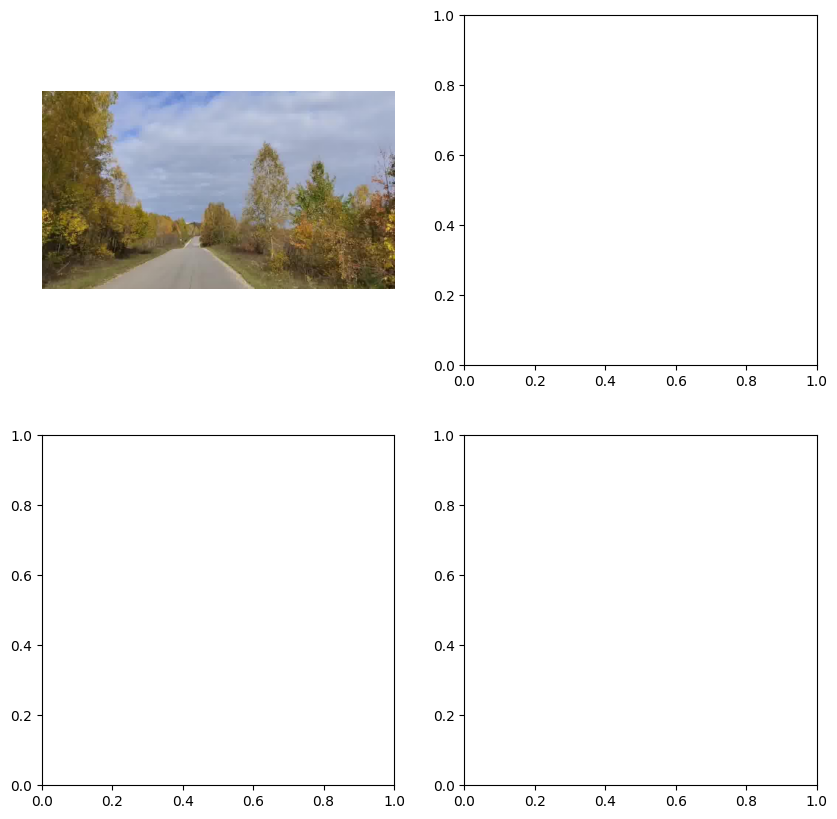

In [3]:


"""
How to visualize COCO annotations on images?

"""


import os
import random
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

def display_images_with_coco_annotations(image_paths, annotations, display_type='both', colors=None):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for ax, img_path in zip(axs.ravel(), image_paths):
        # Load image using OpenCV and convert it from BGR to RGB color space
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax.imshow(image)
        ax.axis('off')  # Turn off the axes

        # Define a default color map if none is provided
        if colors is None:
            colors = plt.cm.get_cmap('tab10')

        # Get image filename to match with annotations
        img_filename = os.path.basename(img_path)
        img_id = next(item for item in annotations['images'] if item["file_name"] == img_filename)['id']

        # Filter annotations for the current image
        img_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == img_id]

        for ann in img_annotations:
            category_id = ann['category_id']
            color = colors(category_id % 10)

            # Display bounding box
            if display_type in ['bbox', 'both']:
                bbox = ann['bbox']
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor=color, facecolor='none')
                ax.add_patch(rect)

            # Display segmentation polygon
            if display_type in ['seg', 'both']:
                for seg in ann['segmentation']:
                    poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                    polygon = patches.Polygon(poly, closed=True, edgecolor=color, fill=False)
                    ax.add_patch(polygon)

    plt.tight_layout()
    plt.show()

# Load COCO annotations
with open(r"E:\Random Python Scripts\Tata HaxS\SAM\sam.v2i.coco-segmentation\test\_annotations.coco.json") as f:
    annotations = json.load(f)

# Get all image files
image_dir = r"E:\Random Python Scripts\Tata HaxS\SAM\sam.v2i.coco-segmentation\test"
all_image_files = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]
random_image_files = random.sample(all_image_files, 4)

# Choose between 'bbox', 'seg', or 'both'
display_type = 'seg'
display_images_with_coco_annotations(random_image_files, annotations, display_type)



#display_images_with_coco_annotations(['livecell_test_images/SKOV3_Phase_F4_2_03d00h00m_4.tif'], annotations, display_type)

In [23]:
import json
import numpy as np
import skimage.draw  # Ensure this import is present
import imageio  # Use imageio for saving PNG images
import os
import shutil
import cv2

def create_mask(image_info, annotations, output_folder):
    # Define class colors
    class_colors = {
        1: (255, 0, 0),    # Red for class 1
        2: (0, 255, 0),    # Green for class 2
    }

    # Create an empty mask as a numpy array
    mask_np = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)

    for ann in annotations:
        if ann['image_id'] == image_info['id']:
            print(f"Processing annotation for image ID {image_info['id']}")  # Debug statement
            print(f"Segmentation: {ann['segmentation']}")  # Print segmentation data

            # Extract segmentation polygons
            for seg in ann['segmentation']:
                if len(seg) > 0:  # Check if the segmentation is valid
                    rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
                    # Ensure the polygon points are within bounds
                    rr = np.clip(rr, 0, mask_np.shape[0] - 1)
                    cc = np.clip(cc, 0, mask_np.shape[1] - 1)

                    mask_np[rr, cc] = ann['category_id']  # Assign class ID to mask pixels

    # Create a color mask
    color_mask = np.zeros((image_info['height'], image_info['width'], 3), dtype=np.uint8)

    # Assign colors to the mask based on class ID
    for class_id, color in class_colors.items():
        color_mask[mask_np == class_id] = color

    # Save the color mask as a PNG using imageio
    mask_path = os.path.join(output_folder, f"{os.path.splitext(image_info['file_name'])[0]}_mask.png")
    imageio.imwrite(mask_path, color_mask)

    print(f"Saved color mask for {image_info['file_name']} to {mask_path}")


#Code to generate masks different colored masks together

In [4]:
import json
import numpy as np
import skimage.draw  # Ensure this import is present
import imageio  # Use imageio for saving PNG images
import os
import shutil
import cv2

def create_mask(image_info, annotations, output_folder):
    # Define class colors
    class_colors = {
        1: (255, 255, 255),  # White for class 1
        2: (255, 255, 255),  # White for class 2
    }

    # Create an empty mask as a numpy array
    mask_np = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)

    for ann in annotations:
        if ann['image_id'] == image_info['id']:
            print(f"Processing annotation for image ID {image_info['id']}")  # Debug statement
            print(f"Segmentation: {ann['segmentation']}")  # Print segmentation data

            # Extract segmentation polygons
            for seg in ann['segmentation']:
                if len(seg) > 0:  # Check if the segmentation is valid
                    rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
                    # Ensure the polygon points are within bounds
                    rr = np.clip(rr, 0, mask_np.shape[0] - 1)
                    cc = np.clip(cc, 0, mask_np.shape[1] - 1)

                    mask_np[rr, cc] = ann['category_id']  # Assign class ID to mask pixels

    # Create a directory for each class if it doesn't exist
    for class_id in class_colors.keys():
        class_folder = os.path.join(output_folder, f'class_{class_id}')
        os.makedirs(class_folder, exist_ok=True)  # Create directory if it doesn't exist

        # Create a color mask for the current class
        color_mask = np.zeros((image_info['height'], image_info['width'], 3), dtype=np.uint8)
        color_mask[mask_np == class_id] = class_colors[class_id]

        # Save the color mask as a PNG using imageio in the respective class folder
        mask_path = os.path.join(class_folder, f"{os.path.splitext(image_info['file_name'])[0]}_mask.png")
        imageio.imwrite(mask_path, color_mask)

        print(f"Saved color mask for {image_info['file_name']} to {mask_path}")

# Code to generate masks white colored masks separately

In [7]:
def main(json_file, mask_output_folder, image_output_folder, original_image_dir):
    # Load COCO JSON annotations
    with open(json_file, 'r') as f:
        data = json.load(f)

    images = data['images']
    annotations = data['annotations']

    # Ensure the output directories exist
    os.makedirs(mask_output_folder, exist_ok=True)
    os.makedirs(image_output_folder, exist_ok=True)

    for img in images:
        # Create the masks
        create_mask(img, annotations, mask_output_folder)

        # Copy original images to the specified folder
        original_image_path = os.path.join(original_image_dir, img['file_name'])
        new_image_path = os.path.join(image_output_folder, os.path.basename(original_image_path))

        shutil.copy2(original_image_path, new_image_path)
        print(f"Copied original image to {new_image_path}")


if __name__ == '__main__':
    original_image_dir = r"E:\Random Python Scripts\Tata HaxS\SAM\sam.v2i.coco-segmentation\valid"  # Correct path to original images
    json_file = r"E:\Random Python Scripts\Tata HaxS\SAM\sam.v2i.coco-segmentation\valid\_annotations.coco.json"
    mask_output_folder = r'E:\Random Python Scripts\Tata HaxS\SAM\Dataset\valid'  
    image_output_folder = r'E:\Random Python Scripts\Tata HaxS\SAM\Dataset\valid\images' 
    main(json_file, mask_output_folder, image_output_folder, original_image_dir)

Processing annotation for image ID 0
Segmentation: [[222, 536, 222, 537, 230, 537, 231, 538, 239, 538, 240, 537, 551, 537, 549, 533, 538, 527, 531, 521, 529, 521, 525, 517, 522, 512, 517, 510, 494, 490, 488, 486, 484, 485, 474, 478, 472, 478, 464, 474, 459, 470, 449, 467, 439, 459, 433, 457, 425, 449, 418, 445, 415, 442, 409, 440, 401, 432, 395, 428, 395, 424, 392, 424, 387, 421, 384, 422, 383, 424, 384, 427, 382, 431, 376, 436, 372, 445, 369, 449, 369, 453, 366, 458, 366, 461, 362, 465, 353, 470, 346, 476, 327, 488, 321, 490, 319, 492, 311, 494, 298, 501, 293, 505, 289, 506, 287, 508, 271, 516, 259, 520, 249, 526, 240, 527, 237, 529, 232, 530]]
Saved color mask for 373_jpg.rf.9907f5a334e9862f83cd15e2171a7f24.jpg to E:\Random Python Scripts\Tata HaxS\SAM\Dataset\valid\class_1\373_jpg.rf.9907f5a334e9862f83cd15e2171a7f24_mask.png
Saved color mask for 373_jpg.rf.9907f5a334e9862f83cd15e2171a7f24.jpg to E:\Random Python Scripts\Tata HaxS\SAM\Dataset\valid\class_2\373_jpg.rf.9907f5a334e9862f